<a href="https://colab.research.google.com/github/sampurnapradhan/Integrated-System-for-News-Classification-and-Fallacy-Detection-in-News-Articles/blob/main/news_classification_and_fallacies_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import spacy
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Download the punkt tokenizer data
nltk.download('punkt_tab')



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Load the datasets
true_df = pd.read_csv('/content/drive/MyDrive/dessertation/datacollection/kaggle/Fake.csv')
false_df = pd.read_csv('/content/drive/MyDrive/dessertation/datacollection/kaggle/True.csv')

# Add labels: 1 for true, 0 for false
true_df['label'] = True
false_df['label'] = False

# Combine the datasets
df = pd.concat([true_df, false_df], ignore_index=True)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display dataset info
print(df.head())


                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017   True  
1       April 5, 2017   False  
2  September 27, 2017   False  
3         May 22, 2017   True  
4       June 24, 2016   False  


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 1.4+ MB


In [ ]:
print(df.dtypes)


title      object
text       object
subject    object
date       object
label        bool
dtype: object


In [ ]:
df.nunique()

,0
title,38729
text,38646
subject,8
date,2397
label,2


In [ ]:
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [ ]:
df["label"]

,label
0,True
1,False
2,False
3,True
4,False
...,...
44893,True
44894,False
44895,False
44896,True


In [ ]:
duplicates = df[df.duplicated()]
print("Duplicate rows:")
print(duplicates)


Duplicate rows:
                                                   title  \
4106   Islamic State claims responsibility for Aden c...   
5547   Turkey seeks life sentences for 60 ex-military...   
5909   Highlights: The Trump presidency on March 31 a...   
6382   Britain preparing to transfer 400 million poun...   
6779   Israel ambassador asks to meet New Zealand pop...   
...                                                  ...   
44673  Kuwait says GCC to keep operating despite Qata...   
44721  Syrian rebels say discussing evacuation from t...   
44786  Russia may widen designation for media outlets...   
44849  Senate tax bill stalls on deficit-focused 'tri...   
44860  British PM May vows to stay as party plotters ...   

                                                    text       subject  \
4106   CAIRO (Reuters) - Militant group Islamic State...     worldnews   
5547   ISTANBUL (Reuters) - Sixty people including a ...     worldnews   
5909   (Reuters) - Highlights of the day 

In [ ]:
# Group duplicate rows and count occurrences
duplicate_groups = df[df.duplicated()].groupby(list(df.columns)).size()
print(duplicate_groups)



title                                                                                                                 text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [ ]:
# Remove duplicate rows and keep only the first occurrence
df = df.drop_duplicates()



# Print the cleaned DataFrame
print(df)


                                                   title  \
0      Ben Stein Calls Out 9th Circuit Court: Committ...   
1      Trump drops Steve Bannon from National Securit...   
2      Puerto Rico expects U.S. to lift Jones Act shi...   
3       OOPS: Trump Just Accidentally Confirmed He Le...   
4      Donald Trump heads for Scotland to reopen a go...   
...                                                  ...   
44893  UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...   
44894  PM May seeks to ease Japan's Brexit fears duri...   
44895  Merkel: Difficult German coalition talks can r...   
44896   Trump Stole An Idea From North Korean Propaga...   
44897  BREAKING: HILLARY CLINTON’S STATE DEPARTMENT G...   

                                                    text       subject  \
0      21st Century Wire says Ben Stein, reputable pr...       US_News   
1      WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2      (Reuters) - Puerto Rico Governor Ricardo Rosse... 

In [ ]:
df["label"]

,label
0,True
1,False
2,False
3,True
4,False
...,...
44893,True
44894,False
44895,False
44896,True


In [ ]:
print(df['label'].unique())


[ True False]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 91.1 MB/s eta 0:00:00


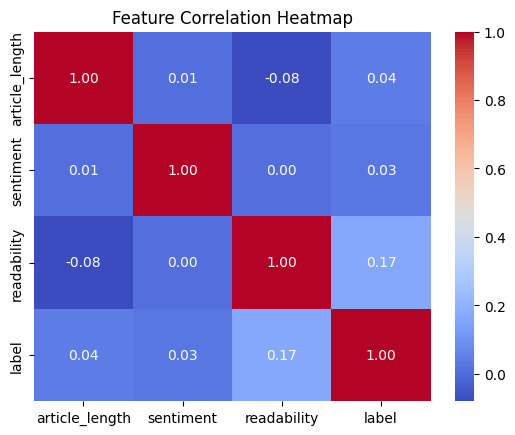

In [ ]:
# Correlation Heatmap
from textblob import TextBlob
!pip install textstat
import textstat


df['article_length'] = df['text'].apply(len)
df['sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['readability'] = df['text'].apply(lambda x: textstat.flesch_reading_ease(x))

# calculate the correlation matrix
correlation_matrix = df[['article_length', 'sentiment', 'readability', 'label']].corr()

# Visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


In [ ]:
# Define the mapping for each category to a unique integer
class_mapping = {
    False : 0,
    True: 1,

}

# Apply the mapping to the 'Rating' column
df['label'] = df['label'].map(class_mapping)


In [ ]:
df

,title,text,subject,date,label,article_length,sentiment,readability
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1,1028,0.083333,51.21
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0,4820,0.086597,48.54
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0,1848,-0.005044,52.29
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1,1244,-0.011161,48.81
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0,3137,0.039347,58.52
...,...,...,...,...,...,...,...,...
44893,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,,politics,"Mar 27, 2017",1,1,0.000000,206.84
44894,PM May seeks to ease Japan's Brexit fears duri...,LONDON/TOKYO (Reuters) - British Prime Ministe...,worldnews,"August 29, 2017",0,4348,0.063350,44.88
44895,Merkel: Difficult German coalition talks can r...,BERLIN (Reuters) - Chancellor Angela Merkel sa...,worldnews,"November 16, 2017",0,434,-0.106061,69.82
44896,Trump Stole An Idea From North Korean Propaga...,Jesus f*cking Christ our President* is a moron...,News,"July 14, 2017",1,5060,-0.033912,70.02


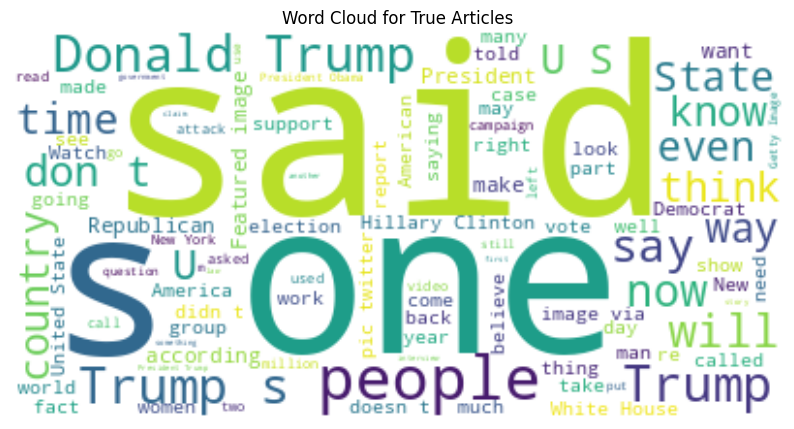

In [ ]:
from wordcloud import WordCloud

# Generate WordClouds for True and False labels
true_text = " ".join(df[df['label'] == 1]['text'])
false_text = " ".join(df[df['label'] == 0]['text'])

# WordCloud for True articles
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(background_color='white', max_words=100).generate(true_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for True Articles")
plt.show()




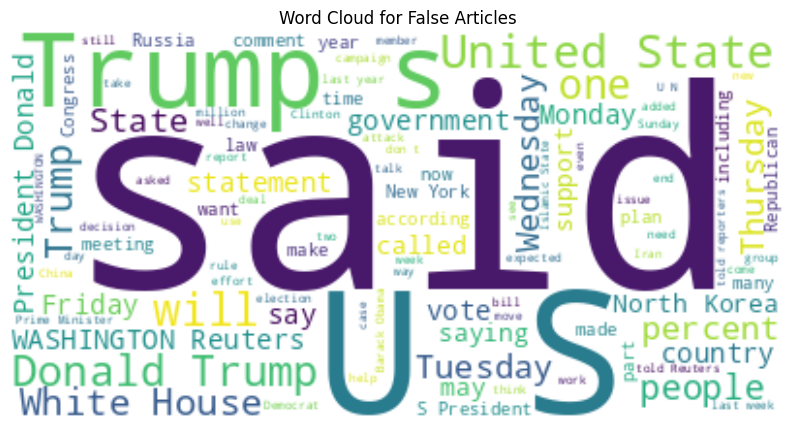

In [ ]:
# WordCloud for False articles
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(background_color='white', max_words=100).generate(false_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for False Articles")
plt.show()

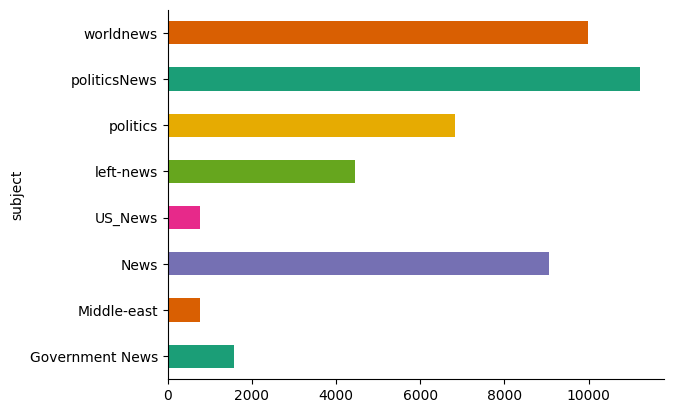

In [ ]:
# @title subject

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('subject').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

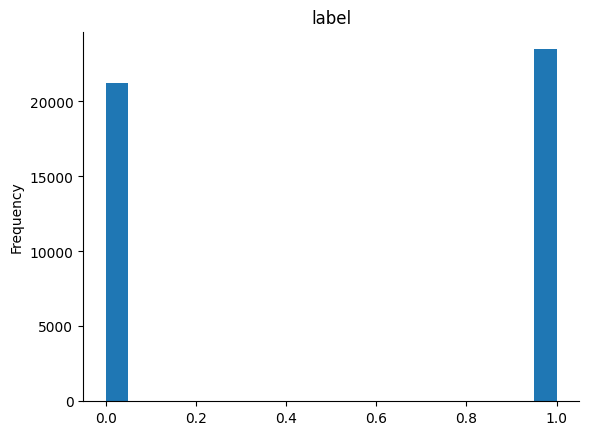

In [ ]:
# @title label

from matplotlib import pyplot as plt
df['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
def preprocess_for_bert(text):
    return re.sub(r'\s+', ' ', text.lower()).strip()

df['title'] = df['title'].apply(preprocess_for_bert)
df['text'] = df['text'].apply(preprocess_for_bert)


In [ ]:
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
!pip install textstat
import textstat

In [ ]:

from sentence_transformers import SentenceTransformer
# Function to Generate Embeddings with Progress Bar
def generate_embeddings_with_progress(model, texts, description="Generating Embeddings"):
    embeddings = []
    for text in tqdm(texts, desc=description):
        embeddings.append(model.encode(text))
    return np.array(embeddings)

# Generate Embeddings with Progress Bar
print("Loading Sentence-BERT model...")
model = SentenceTransformer('all-mpnet-base-v2')  # Use advanced embeddings

print("Generating embeddings for titles...")
title_embeddings = generate_embeddings_with_progress(model, df['title'].tolist(), description="Embedding Titles")

print("Generating embeddings for texts...")
text_embeddings = generate_embeddings_with_progress(model, df['text'].tolist(), description="Embedding Texts")

# Combine Embeddings
combined_embeddings = np.hstack((title_embeddings, text_embeddings))



In [ ]:
# Save title embeddings
np.save('/content/drive/MyDrive/Colab Notebooks/dessertation/embedding/title_embeddings.npy', title_embeddings)

# Save text embeddings
np.save('/content/drive/MyDrive/Colab Notebooks/dessertation/embedding/text_embeddings.npy', text_embeddings)

# Save combined embeddings
np.save('/content/drive/MyDrive/Colab Notebooks/dessertation/embedding/combined_embeddings.npy', combined_embeddings)"""


In [ ]:


# Load combined embeddings
combined_embeddings = np.load('/content/drive/MyDrive/Colab Notebooks/dessertation/embedding/combined_embeddings.npy')

# Verify shape
print("Loaded combined embeddings shape:", combined_embeddings.shape)


Loaded combined embeddings shape: (44689, 1536)


In [ ]:
# Add Additional Features
print("Adding additional features...")
df['article_length'] = df['text'].apply(len)
df['sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['readability'] = df['text'].apply(lambda x: textstat.flesch_reading_ease(x))


Adding additional features...


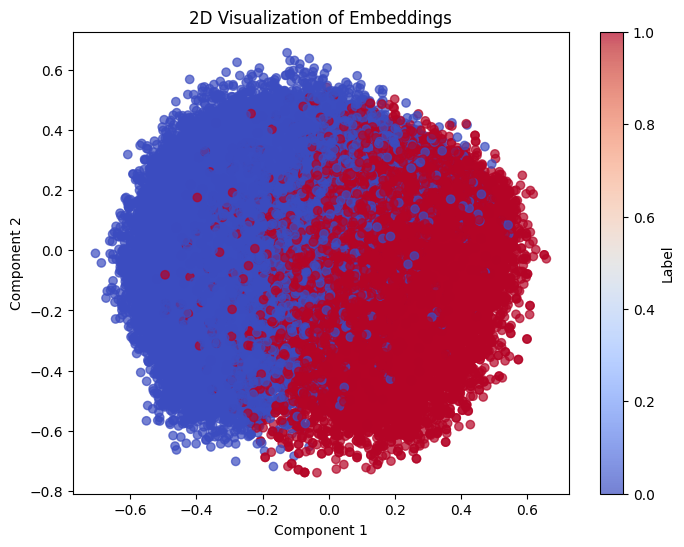

In [ ]:
# PCA or t-SNE for Embeddings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Reduce embeddings using PCA or t-SNE
reduced_embeddings = PCA(n_components=2).fit_transform(combined_embeddings)
# reduced_embeddings = TSNE(n_components=2).fit_transform(combined_embeddings)

# Plot the reduced dimensions
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['label'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Label')
plt.title('2D Visualization of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [ ]:
additional_features = df[['article_length', 'sentiment', 'readability']].values
combined_features = np.hstack((combined_embeddings, additional_features))


In [ ]:
# Handle Class Imbalance with SMOTE
print("Handling class imbalance with SMOTE...")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(combined_features, df['label'])


Handling class imbalance with SMOTE...


In [ ]:
# Class Distribution Before and After SMOTE

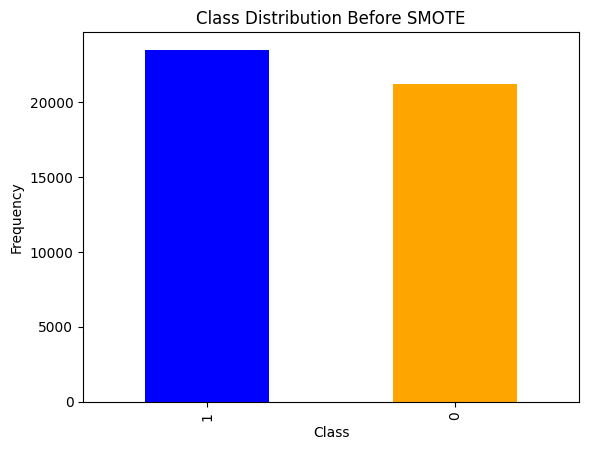

In [ ]:
# Before SMOTE
df['label'].value_counts().plot(kind='bar', title='Class Distribution Before SMOTE', color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()




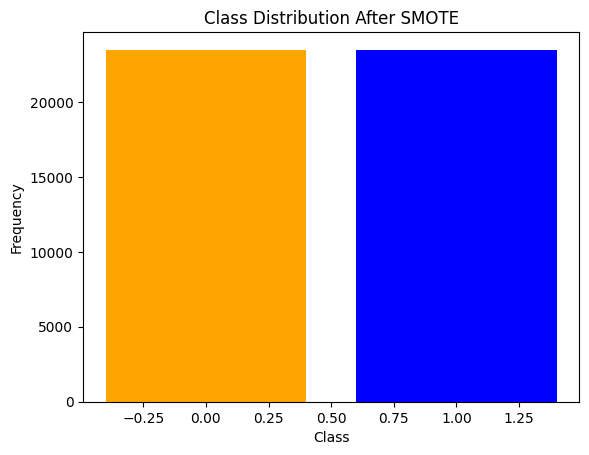

In [ ]:
# After SMOTE
from collections import Counter
smote_class_distribution = Counter(y_resampled)
plt.bar(smote_class_distribution.keys(), smote_class_distribution.values(), color=['blue', 'orange'])
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#  Train-Test Split
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    stratify=y_resampled,
    random_state=42
)


Splitting data into training and testing sets...


In [ ]:
# Install scikeras
!pip install scikeras

# Import of necessary libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# Defining a function to create the model
def create_model(optimizer='adam', dropout_rate=0.1, neurons=256, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wraping the Keras model using KerasClassifier
model = KerasClassifier(model=create_model, verbose=0)

# Defining the hyperparameter grid
param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout_rate': [0.1, 0.2, 0.3],
    'model__neurons': [128, 256, 512],
    'model__learning_rate': [0.001, 0.0005],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}






In [ ]:

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)


In [ ]:

# Fit the model
grid_result = grid.fit(X_train, y_train)




In [ ]:

import pickle

# Save the grid_result object to a file
with open('/content/drive/MyDrive/Colab Notebooks/dessertation/grid_result.pkl', 'wb') as file:
    pickle.dump(grid_result, file)

print("Grid search result saved successfully.")



In [ ]:
import pickle
# Load the grid_result object
with open('/content/drive/MyDrive/Colab Notebooks/dessertation/nn_model/grid_result.pkl', 'rb') as file:
    grid_result = pickle.load(file)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OrdinalEncoder from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator FunctionTransformer from version 1.5.2 when using version 1.6.0. This might lead to breaking code or i

In [ ]:

# Access the best parameters and score
print("Best parameters found: ", grid_result.best_params_)
print("Best cross-validation accuracy: ", grid_result.best_score_)


Best parameters found:  {'batch_size': 32, 'epochs': 30, 'model__dropout_rate': 0.1, 'model__learning_rate': 0.0005, 'model__neurons': 512, 'model__optimizer': 'adam'}
Best cross-validation accuracy:  0.9791822261626608


In [ ]:

# Evaluate on the test set
best_model = grid_result.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test set accuracy: ", test_accuracy)

Test set accuracy:  0.9860519591141397


In [ ]:
import pickle

# Save the best model
best_model_path = '/content/drive/MyDrive/Colab Notebooks/dessertation/best_grid_model.pkl'
with open(best_model_path, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model saved to: {best_model_path}")


Best model saved to: /content/drive/MyDrive/Colab Notebooks/dessertation/best_grid_model.pkl


In [ ]:
# Load the best model
with open(best_model_path, 'rb') as file:
    best_model = pickle.load(file)

print("Best model loaded successfully!")


Best model loaded successfully!


In [ ]:
# Predict probabilities
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (True)

# Predict binary classes
y_pred = best_model.predict(X_test)

# Inspect some predictions
print("Sample Probabilities:", y_pred_prob[:5])
print("Sample Predicted Classes:", y_pred[:5])
print("Sample Actual Classes:", y_test[:5].values)  # Adjust indexing if y_test is not a NumPy array


Sample Probabilities: [9.0198517e-01 9.9045956e-01 1.1809394e-03 5.7697054e-03 1.6511211e-09]
Sample Predicted Classes: [1 1 0 0 0]
Sample Actual Classes: [1 1 0 0 0]


In [ ]:
from sklearn.metrics import classification_report

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Fake", "True"]))



Classification Report:
              precision    recall  f1-score   support

        Fake       0.98      0.99      0.99      4696
        True       0.99      0.98      0.99      4696

    accuracy                           0.99      9392
   macro avg       0.99      0.99      0.99      9392
weighted avg       0.99      0.99      0.99      9392



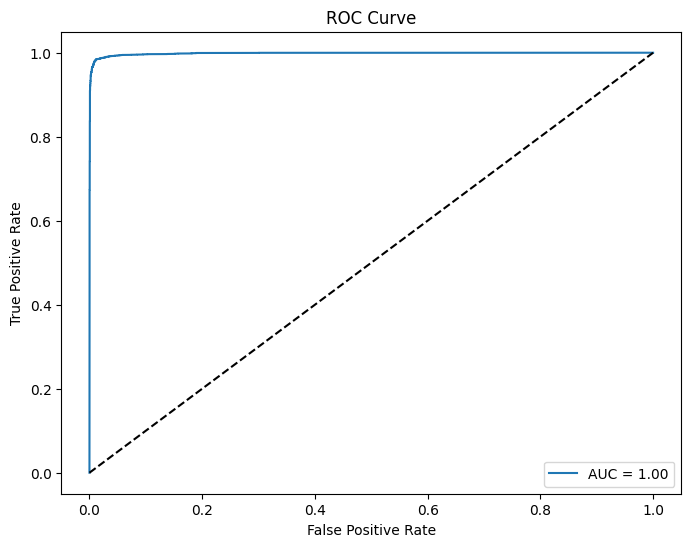

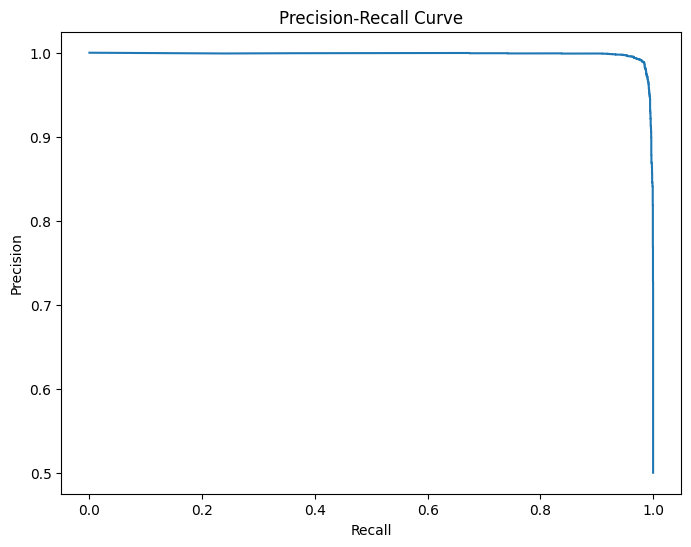

In [ ]:
# ROC and Precision-Recall Curves

from sklearn.metrics import roc_curve, precision_recall_curve, auc

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


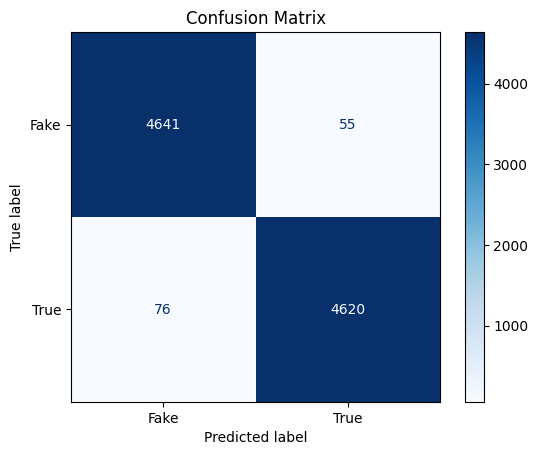

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "True"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Get False Positives and Negatives
false_positives = X_test[(y_pred == 1) & (y_test == 0)]
false_negatives = X_test[(y_pred == 0) & (y_test == 1)]

print("False Positives:")
print(false_positives)

print("\nFalse Negatives:")
print(false_negatives)


False Positives:
[[ 2.10005473e-02  6.74430206e-02 -2.23131068e-02 ...  1.49700000e+03
   4.08653846e-02  6.82600000e+01]
 [-3.50979604e-02  8.68499372e-03 -1.84077527e-02 ...  3.60900000e+03
   2.21700938e-01  5.94300000e+01]
 [-3.07071730e-02  7.47199506e-02 -2.57415958e-02 ...  1.45700000e+03
   1.05263158e-01  6.19700000e+01]
 ...
 [-9.53454804e-03  5.67780919e-02  4.70508821e-03 ...  1.85360000e+04
   4.31615086e-02  5.79100000e+01]
 [-5.12617151e-02  3.51728233e-02 -1.32091188e-02 ...  4.10700000e+03
   5.74493568e-02  5.84827679e+01]
 [-2.19759326e-02  1.29633084e-01 -6.60865195e-03 ...  1.80700000e+03
   2.28321678e-01  6.43000000e+01]]

False Negatives:
[[ 8.33056215e-03 -3.03032529e-03  4.76578623e-03 ...  1.25900000e+03
   9.16971917e-02  4.95500000e+01]
 [-2.76327133e-02  5.21269031e-02 -1.63594056e-02 ...  2.85200000e+03
   5.53774351e-02  6.11600000e+01]
 [-1.01505425e-02  6.49256781e-02 -4.08883281e-02 ...  2.18300000e+03
   7.90816327e-03  6.27800000e+01]
 ...
 [-1.5098

FALLACY MODEL


In [ ]:
# Import libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from bs4 import BeautifulSoup
import json




In [ ]:
# Load the JSON dataset
dataset = '/content/drive/MyDrive/dessertation/datacollection/train.json'
# Load the dataset
with open(dataset, "r") as f:
    data = json.load(f)

# Flatten the dataset
rows = []
for article in data:
    article_title = article["title"]
    article_content = BeautifulSoup(article["content"], "html.parser").get_text()
    for comment in article["comments"]:
        rows.append({
            "article_id": article["id"],
            "article_title": article_title,
            "article_content": article_content,
            "comment_id": comment["id"],
            "comment_text": comment["comment"],
            "fallacy_type": comment["fallacy"]
        })

# Create a DataFrame
f_df = pd.DataFrame(rows)

In [ ]:
f_df

,article_id,article_title,article_content,comment_id,comment_text,fallacy_type
0,262,"Even with a law, São Paulo's municipalities ar...",\nThis story was written by Paulo Talarico and...,5584,Lack of transparency in government isn't unexp...,none
1,262,"Even with a law, São Paulo's municipalities ar...",\nThis story was written by Paulo Talarico and...,5582,While the issues discussed here should be addr...,appeal to authority
2,262,"Even with a law, São Paulo's municipalities ar...",\nThis story was written by Paulo Talarico and...,5583,The excuse that Brazilian municipalities do no...,none
3,262,"Even with a law, São Paulo's municipalities ar...",\nThis story was written by Paulo Talarico and...,6183,This is what's to be expected of developing an...,none
4,262,"Even with a law, São Paulo's municipalities ar...",\nThis story was written by Paulo Talarico and...,6182,"Sad to say, I have to agree with you. Rulers c...",appeal to tradition
...,...,...,...,...,...,...
5365,644,"For Asian activists, boycotting Disney's ‘Mula...",\nActivists from a number of Asian countries a...,9129,A boycott can be a powerful weapon. Let's hope...,none
5366,644,"For Asian activists, boycotting Disney's ‘Mula...",\nActivists from a number of Asian countries a...,9128,This is something we should all participate in...,appeal to authority
5367,644,"For Asian activists, boycotting Disney's ‘Mula...",\nActivists from a number of Asian countries a...,11228,"The movie is part of the problem, though. Di...",none
5368,644,"For Asian activists, boycotting Disney's ‘Mula...",\nActivists from a number of Asian countries a...,11229,"The propaganda does happen in every country, a...",slippery slope


In [ ]:
f_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5370 entries, 0 to 5369
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_id       5370 non-null   int64 
 1   article_title    5370 non-null   object
 2   article_content  5370 non-null   object
 3   comment_id       5370 non-null   object
 4   comment_text     5370 non-null   object
 5   fallacy_type     5370 non-null   object
dtypes: int64(1), object(5)
memory usage: 251.8+ KB


In [ ]:
f_df.isnull().sum()

,0
article_id,0
article_title,0
article_content,0
comment_id,0
comment_text,0
fallacy_type,0


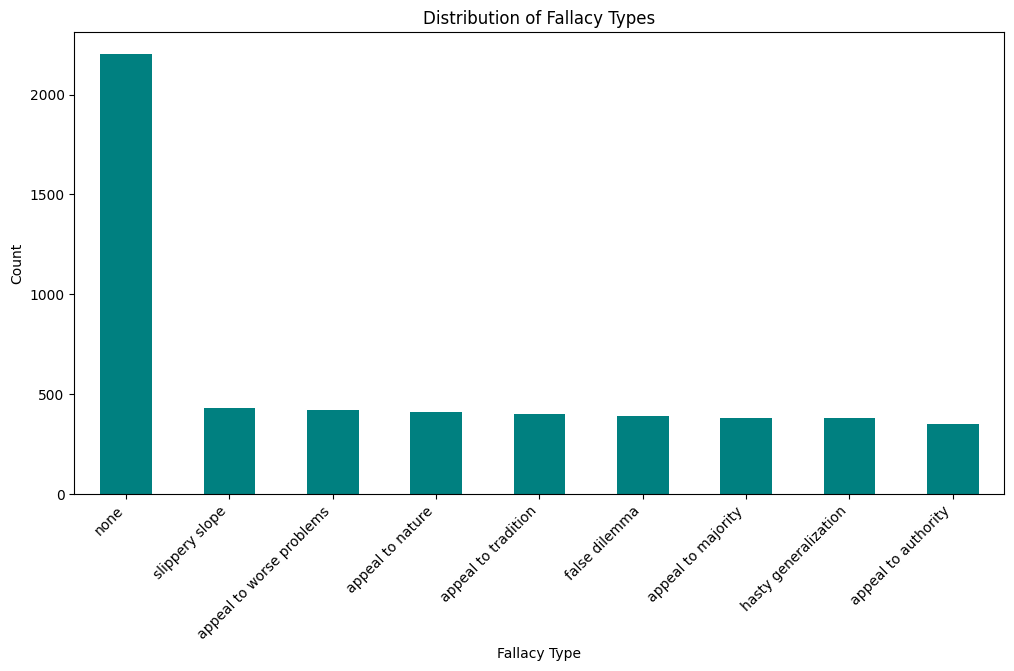

In [ ]:
# Distribution of Fallacy Types
import matplotlib.pyplot as plt

# Count each fallacy type
fallacy_counts = f_df['fallacy_type'].value_counts()

# Plot fallacy type distribution
plt.figure(figsize=(12, 6))
fallacy_counts.plot(kind='bar', color='teal')
plt.title('Distribution of Fallacy Types')
plt.xlabel('Fallacy Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
# Create binary classification column
f_df["fallacy_present"] = f_df["fallacy_type"].apply(lambda x: 0 if x == "none" else 1)


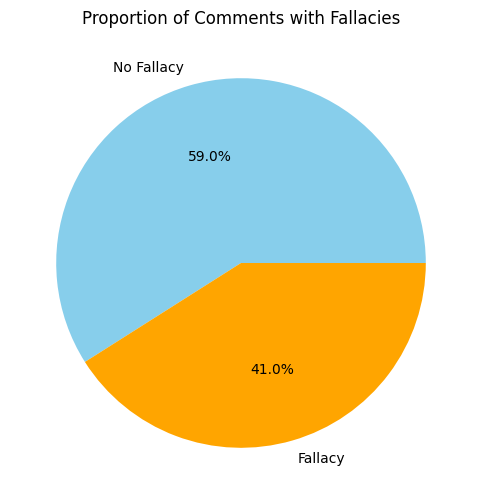

In [ ]:
# Count presence vs. absence of fallacies
fallacy_presence_counts = f_df['fallacy_present'].value_counts()

# Plot fallacy presence distribution
plt.figure(figsize=(8, 6))
fallacy_presence_counts.plot(kind='pie', labels=['No Fallacy', 'Fallacy'], autopct='%1.1f%%', colors=['skyblue', 'orange'])
plt.title('Proportion of Comments with Fallacies')
plt.ylabel('')
plt.show()


In [ ]:
# Use only comment text for classification
f_df["input_text"] = f_df["comment_text"]

In [ ]:
# Stratified train, val, and test split
train_df, temp_df = train_test_split(f_df, test_size=0.3, random_state=42, stratify=f_df["fallacy_present"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["fallacy_present"])

In [ ]:

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train = train_df["input_text"]
y_train = train_df["fallacy_present"]


In [ ]:

# Tokenize text for SMOTE
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
X_train_tokenized = tokenizer(list(X_train), padding=True, truncation=True, max_length=512, return_tensors="np")["input_ids"]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:


# Apply SMOTE
X_smote, y_smote = smote.fit_resample(X_train_tokenized, y_train)

In [ ]:

# Convert back to text
balanced_train_df = pd.DataFrame({
    "input_text": tokenizer.batch_decode(X_smote, skip_special_tokens=True),
    "fallacy_present": y_smote
})

In [ ]:
# Dataset class
class FallacyDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        inputs = self.tokenizer(
            row["input_text"],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": torch.tensor(row["fallacy_present"], dtype=torch.long)
        }


In [ ]:
# Create datasets and dataloaders
train_dataset = FallacyDataset(balanced_train_df, tokenizer, max_len=512)
val_dataset = FallacyDataset(val_df, tokenizer, max_len=512)
test_dataset = FallacyDataset(test_df, tokenizer, max_len=512)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import os
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Define model path
model_path = "/content/drive/MyDrive/fallacy_model"

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check if the model already exists
if os.path.exists(model_path):
    print("Loading existing model...")
    fallacy_model = BertForSequenceClassification.from_pretrained(model_path)
    tokenizer = BertTokenizer.from_pretrained(model_path)
    fallacy_model.to(device)
    print("Model loaded .")
else:
    print("No saved model found. Proceeding with training...")



Loading existing model...
Model loaded .


In [ ]:
# Evaluate on test set
fallacy_model.eval()
test_predictions, test_labels = [], []
for batch in test_loader:
    with torch.no_grad():
        inputs = {key: val.to(device) for key, val in batch.items()}
        outputs = fallacy_model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)
        test_predictions.extend(preds.cpu().numpy())
        test_labels.extend(batch["labels"].cpu().numpy())



Test Classification Report:
              precision    recall  f1-score   support

  No Fallacy       0.78      0.68      0.73       331
     Fallacy       0.79      0.87      0.83       475

    accuracy                           0.79       806
   macro avg       0.79      0.77      0.78       806
weighted avg       0.79      0.79      0.79       806



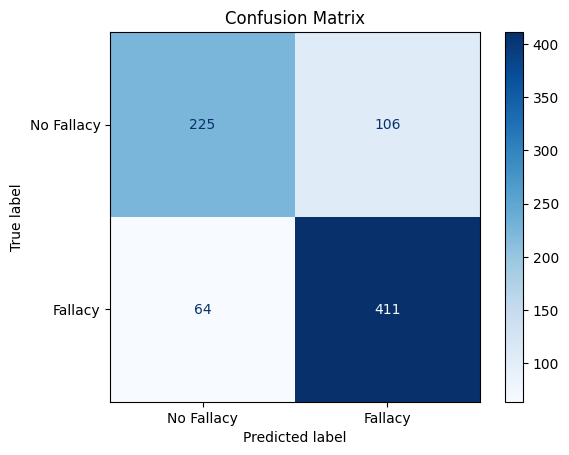

In [ ]:
 #Generate classification report and confusion matrix
print("Test Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=["No Fallacy", "Fallacy"]))

cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fallacy", "Fallacy"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

**Integration of News Classification and Logical Fallacy Detection Models**

In [ ]:
from nltk.tokenize import sent_tokenize

def process_news_article(title, text):
    # Generate embeddings
    title_embedding = news_model.encode([title])
    text_embedding = news_model.encode([text])
    combined_embedding = np.hstack((title_embedding, text_embedding))

    # Generate additional features
    article_length = np.array([[len(text)]])
    sentiment = np.array([[TextBlob(text).sentiment.polarity]])
    readability_score = np.array([[textstat.flesch_reading_ease(text)]])
    combined_features = np.hstack((combined_embedding, article_length, sentiment, readability_score))

    # Predict
    predicted_prob = best_model.predict_proba(combined_features)[0]
    predicted_class = best_model.predict(combined_features)[0]
    classification = "True" if predicted_class == 0 else "Fake"

    # Detect fallacies
    sentences = sent_tokenize(text)
    fallacy_fragments = []
    for sentence in sentences:
        encoding = tokenizer(
            sentence,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            outputs = fallacy_model(**encoding)
            probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
            if probs[1] > 0.5:
                fallacy_fragments.append(sentence)

    fallacy_percentage = (len(fallacy_fragments) / len(sentences)) * 100 if sentences else 0

    return {
        "title": title,
        "classification": classification,
        "confidence": predicted_prob,
        "fallacy_percentage": fallacy_percentage,
        "fallacy_sentences": fallacy_fragments
    }




In [ ]:
# Testing
while True:
    print("\nEnter news article details (or type 'exit' to quit):")
    title = input("Title: ")
    if title.lower() == "exit":
        break
    text = input("Text: ")

    results = process_news_article(title, text)
    print("\nResults:")
    print(f"Title: {results['title']}")
    print(f"Classification: {results['classification']}")

    print(f"Fallacy Percentage: {results['fallacy_percentage']:.2f}%")
    if results["fallacy_sentences"]:

        print("Sentences with fallacies:")
        for frag in results["fallacy_sentences"]:
            print(f" - {frag}")
    else:
        print("No fallacies detected.")
    print("-" * 80)


Enter news article details (or type 'exit' to quit):
Title: Senate leader McConnell sees a more collegial 2018
Text: WASHINGTON (Reuters) - U.S. Senate Majority Leader Mitch McConnell on Friday said a shifting landscape will lead him to work with Democrats on immigration and financial regulation early in the new year, following a year of acrimony and partisan legislation. In an end-of-year news conference, McConnell touted a list of Republican accomplishments since President Donald Trump took office in January. It started with the confirmation of Neil Gorsuch to the Supreme Court and ended with an overhaul of the  U.S. tax code. But in January, McConnell’s already razor-thin 52-48 Republican majority will shrink to 51-49 with the swearing in of Senator-elect Doug Jones, the Democrat who surprised the political world with a win in a special election in the deeply Republican state of Alabama. Adding to McConnell’s difficulties, special Senate procedures are fading that allowed him to pa

In [ ]:
# Testing
while True:
    print("\nEnter news article details (or type 'exit' to quit):")
    title = input("Title: ")
    if title.lower() == "exit":
        break
    text = input("Text: ")

    results = process_news_article(title, text)
    print("\nResults:")
    print(f"Title: {results['title']}")
    print(f"Classification: {results['classification']}")

    print(f"Fallacy Percentage: {results['fallacy_percentage']:.2f}%")
    if results["fallacy_sentences"]:

        print("Sentences with fallacies:")
        for frag in results["fallacy_sentences"]:
            print(f" - {frag}")
    else:
        print("No fallacies detected.")
    print("-" * 80)



Enter news article details (or type 'exit' to quit):
Title: Rival Politician’s Policies Are Wrong Because He’s Inexperienced
Text: How can anyone trust the new senator's economic policies when he has never run a business in his life? He’s just a career politician who can’t possibly understand the challenges of running a country. Clearly, his policies are flawed because he lacks the expertise and wisdom of seasoned professionals.

Results:
Title: Rival Politician’s Policies Are Wrong Because He’s Inexperienced
Classification: Fake
Fallacy Percentage: 33.33%
Sentences with fallacies:
 - Clearly, his policies are flawed because he lacks the expertise and wisdom of seasoned professionals.
--------------------------------------------------------------------------------

Enter news article details (or type 'exit' to quit):
Title: Environmentalists Want to Ban Cars Completely
Text: Environmental activists are calling for an outright ban on all cars, claiming that vehicles are destroying the 